In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/happpp/happyp.jpeg
/kaggle/input/rrrrrrr/Rwan.png
/kaggle/input/rawankhaled/WhatsApp Image 2023-11-27 at 4.49.50 AM.jpeg
/kaggle/input/angrypic/angry.jpeg
/kaggle/input/sadddd/sad.jpg
/kaggle/input/happyp/happy.webp
/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv
/kaggle/input/souuuu/WhatsApp Image 2023-11-27 at 5.20.29 AM.jpeg


In [2]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

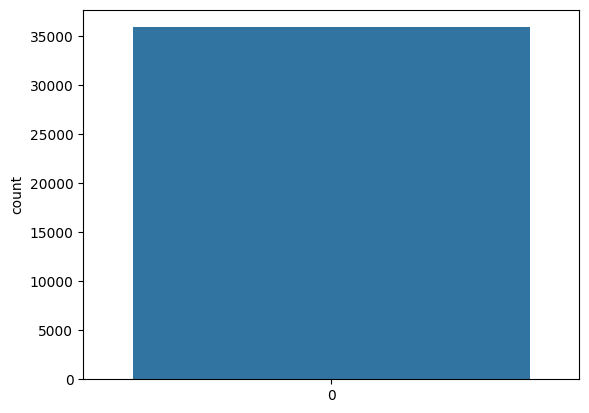

In [7]:
sns.countplot(df.emotion)
pyplot.show()

In [8]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

/tmp/ipykernel_32/2088611314.py:15: UserWarning: The figure layout has changed to tight
  pyplot.tight_layout()


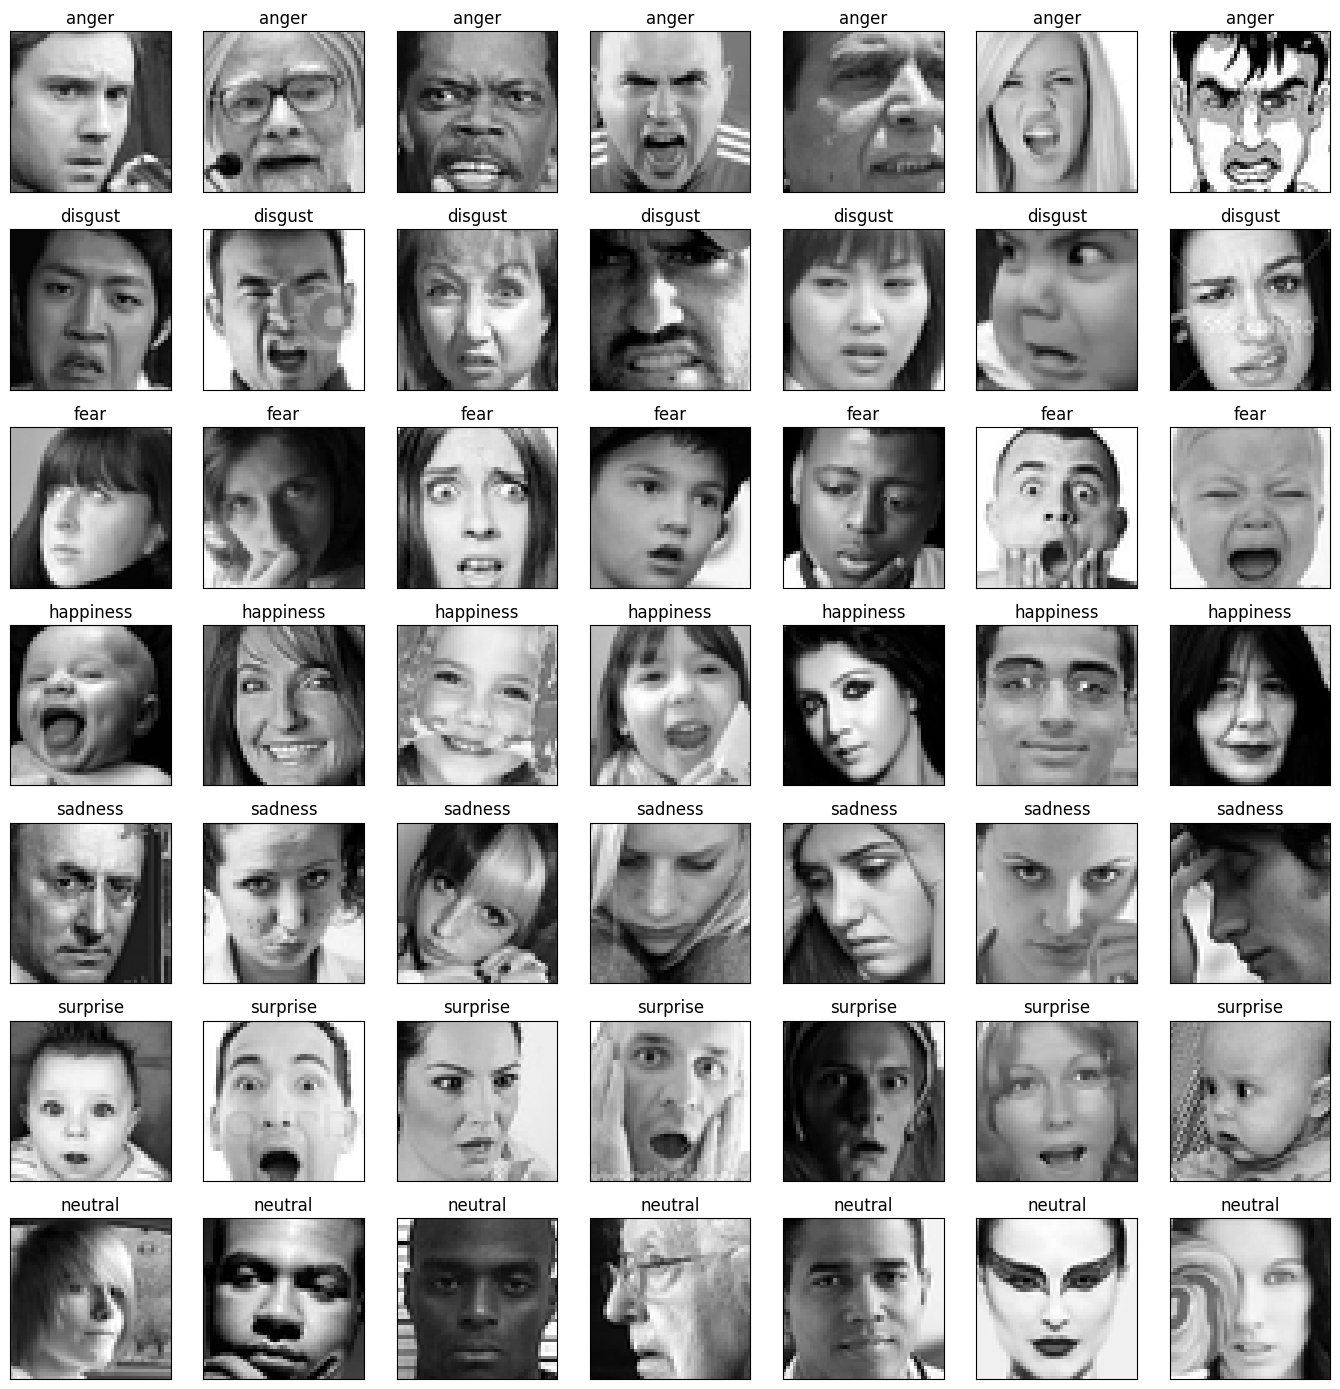

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [14]:
INTERESTED_LABELS = [0,3, 4, 6]

In [15]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(26217, 3)

In [16]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [17]:
img_array.shape

(26217, 48, 48, 1)

In [19]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels, 4)
img_labels.shape

(26217, 4)

In [20]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 3: 1, 4: 2, 6: 3}


In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((23595, 48, 48, 1), (2622, 48, 48, 1), (23595, 4), (2622, 4))

In [22]:
del df
del img_array
del img_labels

In [23]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [24]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [25]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [26]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [27]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [29]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/tmp/ipykernel_32/2966849243.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-12-01 13:34:31.965785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDCNN/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


737/737 [==============================] - 28s 30ms/step - loss: 1.5865 - accuracy: 0.3167 - val_loss: 1.2774 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 2/100
737/737 [==============================] - 22s 29ms/step - loss: 1.3012 - accuracy: 0.3978 - val_loss: 1.1462 - val_accuracy: 0.4893 - lr: 0.0010
Epoch 3/100
737/737 [==============================] - 22s 29ms/step - loss: 1.1872 - accuracy: 0.4641 - val_loss: 1.1246 - val_accuracy: 0.5324 - lr: 0.0010
Epoch 4/100
737/737 [==============================] - 22s 29ms/step - loss: 1.0732 - accuracy: 0.5256 - val_loss: 0.8917 - val_accuracy: 0.6274 - lr: 0.0010
Epoch 5/100
737/737 [==============================] - 22s 29ms/step - loss: 1.0056 - accuracy: 0.5690 - val_loss: 0.8863 - val_accuracy: 0.6255 - lr: 0.0010
Epoch 6/100
737/737 [==============================] - 22s 29ms/step - loss: 0.9538 - accuracy: 0.5972 - val_loss: 0.8240 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 7/100
737/737 [==============================] - 22s 29ms/

/tmp/ipykernel_32/1438442085.py:14: UserWarning: The figure layout has changed to tight
  pyplot.tight_layout()


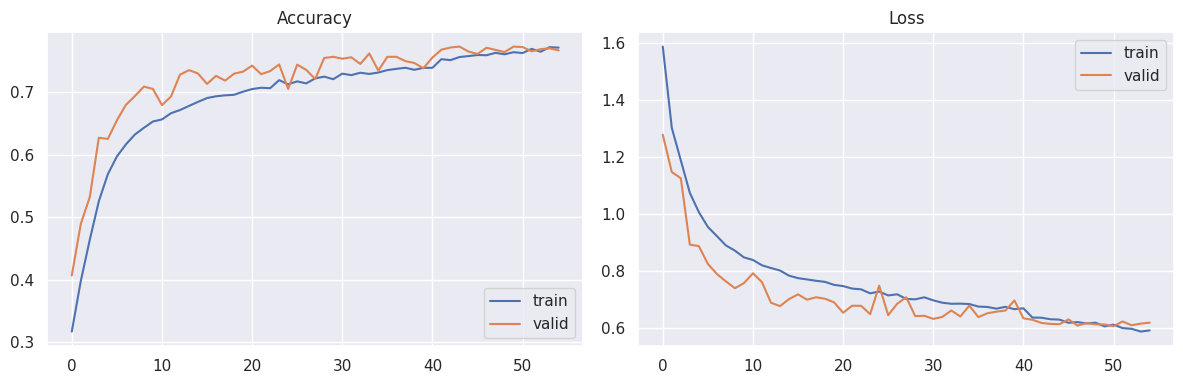

In [30]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

82/82 [==============================] - 1s 7ms/step
total wrong validation predictions: 594


              precision    recall  f1-score   support

           0       0.72      0.72      0.72       495
           1       0.91      0.92      0.91       899
           2       0.74      0.62      0.68       608
           3       0.67      0.76      0.71       620

    accuracy                           0.77      2622
   macro avg       0.76      0.75      0.75      2622
weighted avg       0.78      0.77      0.77      2622



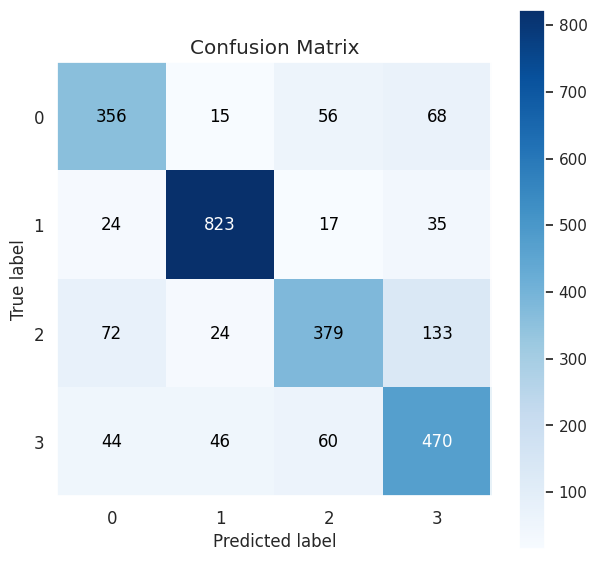

In [31]:
yhat_valid_probabilities = model.predict(X_valid)
yhat_valid = np.argmax(yhat_valid_probabilities, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7, 7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [33]:
mapper = {
  
    0: "negative",
    1: "positive",
    2: "negative",
    3: "neutral"
}

1/1 [==============================] - 0s 261ms/step


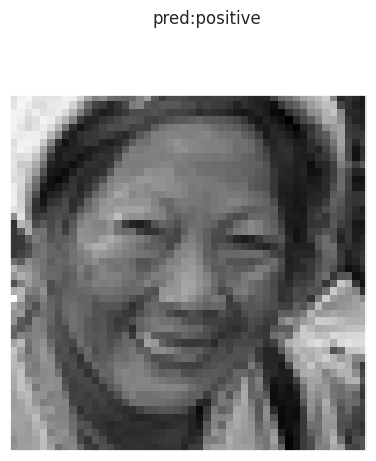

In [34]:
#for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
ax = pyplot.subplot(1, 1, 1)
sample_img_sad = X_valid[1, :, :, 0]
prediction_sad = model.predict(sample_img_sad.reshape(1, 48, 48, 1))[0]
predicted_class_sad = np.argmax(prediction_sad)
ax.imshow(sample_img_sad, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.4, 1.2, f"pred:{mapper[predicted_class_sad]}", transform=ax.transAxes)
"""
ax = pyplot.subplot(2, 9, 10)
sample_img_neutral = X_valid[1, :, :, 0]
ax.imshow(sample_img_neutral, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
"""

pyplot.tight_layout()


1/1 [==============================] - 0s 21ms/step


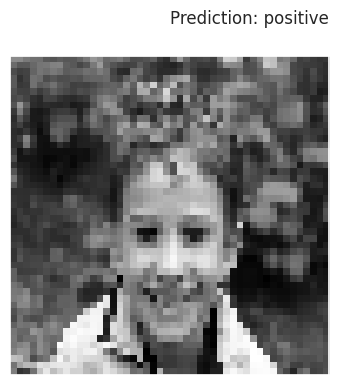

positive


In [35]:
import cv2
input_image_path = "/kaggle/input/happyp/happy.webp"  # Replace with the path to your input image
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Resize the image to (48, 48)
input_image = cv2.resize(input_image, (48, 48))

# Convert the resized image to float32 and normalize
input_image = input_image.astype('float32') / 255.0

# Reshape the image to (48, 48, 1)
input_image = input_image.reshape(48, 48, 1)

# Make predictions for the input image
prediction = model.predict(input_image.reshape(1, 48, 48, 1))[0]
predicted = np.argmax(prediction)

# Create a figure for displaying the input image and prediction
fig = pyplot.figure(1, (4, 4))
ax = pyplot.subplot(1, 1, 1)
ax.imshow(input_image[:, :, 0], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

# Display the prediction on the input image
ax.text(0.5, 1.1, f"Prediction: {mapper[predicted]}", transform=ax.transAxes)

pyplot.tight_layout()
pyplot.show()

print(mapper[predicted])

1/1 [==============================] - 0s 22ms/step


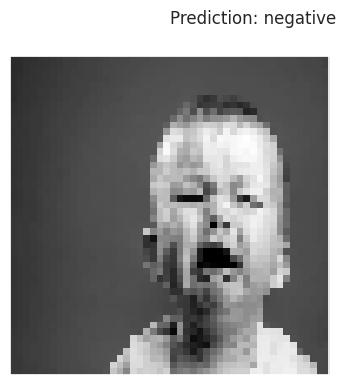

negative


In [36]:
input_image_path = "/kaggle/input/sadddd/sad.jpg"  # Replace with the path to your input image
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Resize the image to (48, 48)
input_image = cv2.resize(input_image, (48, 48))

# Convert the resized image to float32 and normalize
input_image = input_image.astype('float32') / 255.0

# Reshape the image to (48, 48, 1)
input_image = input_image.reshape(48, 48, 1)

# Make predictions for the input image
prediction = model.predict(input_image.reshape(1, 48, 48, 1))[0]
predicted = np.argmax(prediction)

# Create a figure for displaying the input image and prediction
fig = pyplot.figure(1, (4, 4))
ax = pyplot.subplot(1, 1, 1)
ax.imshow(input_image[:, :, 0], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

# Display the prediction on the input image
ax.text(0.5, 1.1, f"Prediction: {mapper[predicted]}", transform=ax.transAxes)

pyplot.tight_layout()
pyplot.show()

print(mapper[predicted])

1/1 [==============================] - 0s 23ms/step


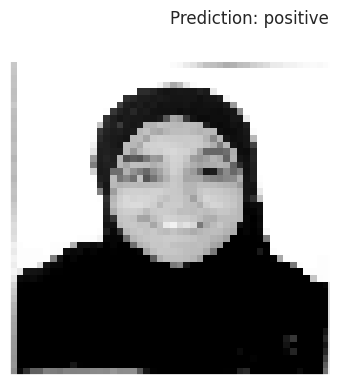

positive


In [37]:
input_image_path = "/kaggle/input/rawankhaled/WhatsApp Image 2023-11-27 at 4.49.50 AM.jpeg"  # Replace with the path to your input image
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Resize the image to (48, 48)
input_image = cv2.resize(input_image, (48, 48))

# Convert the resized image to float32 and normalize
input_image = input_image.astype('float32') / 255.0

# Reshape the image to (48, 48, 1)
input_image = input_image.reshape(48, 48, 1)

# Make predictions for the input image
prediction = model.predict(input_image.reshape(1, 48, 48, 1))[0]
predicted = np.argmax(prediction)

# Create a figure for displaying the input image and prediction
fig = pyplot.figure(1, (4, 4))
ax = pyplot.subplot(1, 1, 1)
ax.imshow(input_image[:, :, 0], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

# Display the prediction on the input image
ax.text(0.5, 1.1, f"Prediction: {mapper[predicted]}", transform=ax.transAxes)

pyplot.tight_layout()
pyplot.show()

print(mapper[predicted])

1/1 [==============================] - 0s 20ms/step


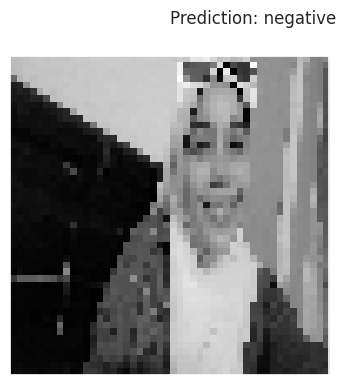

negative


In [38]:
input_image_path = "/kaggle/input/souuuu/WhatsApp Image 2023-11-27 at 5.20.29 AM.jpeg"  # Replace with the path to your input image
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Resize the image to (48, 48)
input_image = cv2.resize(input_image, (48, 48))

# Convert the resized image to float32 and normalize
input_image = input_image.astype('float32') / 255.0

# Reshape the image to (48, 48, 1)
input_image = input_image.reshape(48, 48, 1)

# Make predictions for the input image
prediction = model.predict(input_image.reshape(1, 48, 48, 1))[0]
predicted = np.argmax(prediction)

# Create a figure for displaying the input image and prediction
fig = pyplot.figure(1, (4, 4))
ax = pyplot.subplot(1, 1, 1)
ax.imshow(input_image[:, :, 0], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

# Display the prediction on the input image
ax.text(0.5, 1.1, f"Prediction: {mapper[predicted]}", transform=ax.transAxes)

pyplot.tight_layout()
pyplot.show()

print(mapper[predicted])

1/1 [==============================] - 0s 23ms/step


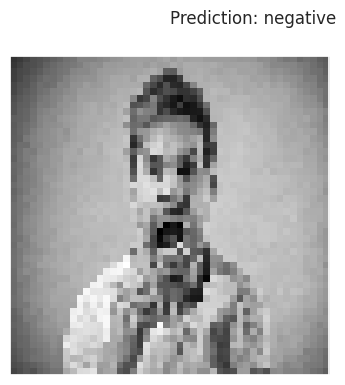

negative


In [39]:
input_image_path = "/kaggle/input/angrypic/angry.jpeg"  # Replace with the path to your input image
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Resize the image to (48, 48)
input_image = cv2.resize(input_image, (48, 48))

# Convert the resized image to float32 and normalize
input_image = input_image.astype('float32') / 255.0

# Reshape the image to (48, 48, 1)
input_image = input_image.reshape(48, 48, 1)

# Make predictions for the input image
prediction = model.predict(input_image.reshape(1, 48, 48, 1))[0]
predicted = np.argmax(prediction)

# Create a figure for displaying the input image and prediction
fig = pyplot.figure(1, (4, 4))
ax = pyplot.subplot(1, 1, 1)
ax.imshow(input_image[:, :, 0], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

# Display the prediction on the input image
ax.text(0.5, 1.1, f"Prediction: {mapper[predicted]}", transform=ax.transAxes)

pyplot.tight_layout()
pyplot.show()

print(mapper[predicted])

1/1 [==============================] - 0s 23ms/step


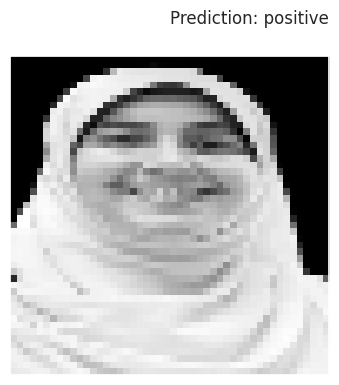

positive


In [40]:
input_image_path = "/kaggle/input/rrrrrrr/Rwan.png"  # Replace with the path to your input image
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Resize the image to (48, 48)
input_image = cv2.resize(input_image, (48, 48))

# Convert the resized image to float32 and normalize
input_image = input_image.astype('float32') / 255.0

# Reshape the image to (48, 48, 1)
input_image = input_image.reshape(48, 48, 1)

# Make predictions for the input image
prediction = model.predict(input_image.reshape(1, 48, 48, 1))[0]
predicted = np.argmax(prediction)

# Create a figure for displaying the input image and prediction
fig = pyplot.figure(1, (4, 4))
ax = pyplot.subplot(1, 1, 1)
ax.imshow(input_image[:, :, 0], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

# Display the prediction on the input image
ax.text(0.5, 1.1, f"Prediction: {mapper[predicted]}", transform=ax.transAxes)

pyplot.tight_layout()
pyplot.show()

print(mapper[predicted])

In [ ]:
import pickle

pickle.dump(model, open('/kaggle/working/model_saved3', 'wb'))

In [ ]:
import tensorflow.keras as keras

# Save the model
model.save('model_saved3.h5')